In [3]:
__author__ = "me"
__date__ = "2016_02_01"


import matplotlib
matplotlib.use('Agg')


%pylab inline
import matplotlib.pyplot as plt

import sqlite3
import datetime
import dateutil.parser
import pandas as pd

import os
import ast
from ipynotifyer import notifyOnComplete as nf

Populating the interactive namespace from numpy and matplotlib


In [4]:
@nf
def getDF(path):
    print 'connecting!'
    conn = sqlite3.connect(path)
    print 'aquiring...'    
    columns2 = ('id', 'user_id', 'application', 'postalCode', 'ts')

    df = pd.read_sql('SELECT id, user_id, application, postalCode, ts FROM tweets', 
                       conn, parse_dates='ts', columns=columns2)
    
    df[pd.notnull(df.postalCode)]['postalCode'] = df[pd.notnull(df.postalCode)].postalCode.apply(lambda x: '{0:05d}'.format(int(x)))
    return df


## Read Database to Dataframe

In [5]:
path = '../../data/MASTERDB/2016-04-15_v4.db'
df = getDF(path)

connecting!
aquiring...


/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
df.shape

(23046861, 5)

## Average Week 

In [80]:
def averageWeek(df, ax=None, tcol='ts', ccol='id', tperiod='15Min', plotGraph=True, label=None, 
                treshold=0, normalize=True, verbose=True, mask=None, **kwargs):
    '''calculate average week on ts'''
    
    df.rename(columns={tcol:'ts',ccol:'id'},inplace=1) # rename to convention
    
    
    s = df[['id', 'ts']].set_index('ts').resample(tperiod, how='count').reset_index()

    ## Drop empty Days
    if mask:
        s = s[s['ts'].apply(lambda x: x.date() in mask)]

    s['id'] = s['id'].astype(float)
    s['ts'] = s.ts.apply(lambda x: datetime.datetime(year=2015,month=1, 
                                                              day=(x.weekday()+1), 
                                                              hour=x.hour, 
                                                              minute = x.minute))
    
    s = s.groupby(['ts']).agg(['mean','std'])
    s.columns = ('id', 'std')

    
    if not label:
        label = ccol
    
    if s['id'].sum() >= treshold:
        if normalize:
            sNorm = (1.0*s[['id']]/s[['id']].sum())
        else:
            sNorm = s[['id']]
        
        sNorm.rename(columns={'id':label}, inplace=1)
        if plotGraph:
            sNorm.plot(ax=ax, legend=False, **kwargs);

        
        
    else:
        if verbose:
            print label, 'didnt pass treshhold:', s['id'].sum()
        else:
            pass
    
    return s.rename(columns={'id':label})

In [65]:
    
@nf  
def bulkWeeks(df, attr, title='', av=False, th=0, legend=False,  tperiod='15Min', **kwargs):
    fig, ax = plt.subplots(figsize=(18,6))
    weeks = []

    # propert days to use, no matter what time period (not empty)
    m = df[['id', 'ts']].set_index('ts').resample('1D', how='count')
    proper_dates = [x.date() for x in m.index[m['id']>0].tolist()]


    for name, g in df.groupby(attr):
        
        zs = averageWeek(g, ax=ax, label=name, alpha=.5, treshold=th,tperiod=tperiod, mask=proper_dates, **kwargs)
        weeks.append(zs)
    
    data = pd.concat(weeks, axis=1)
    if av:
        d = data.mean(axis=1)
        (1.0*d/d.sum()).plot(ax=ax, lw=1.4, color='k', label='Average')


    ax.set_title('%s, treshold=%d,timeperiod=%s' % (title,th, tperiod ), fontsize=15);
    
    if legend:
        ax.legend()

    labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    dates = [datetime.datetime(year=2015, month=1, day=i, hour=0, minute=0) for i in range(1,8)]

    ax.set_xticklabels([],minor=False) # the default
    ax.set_xticklabels(labels,minor=True)

    for d in dates:
        ax.axvline(x=d, ymin=0, ymax=1)

    return data
    
    

IndentationError: expected an indented block (<ipython-input-65-095b06300065>, line 4)

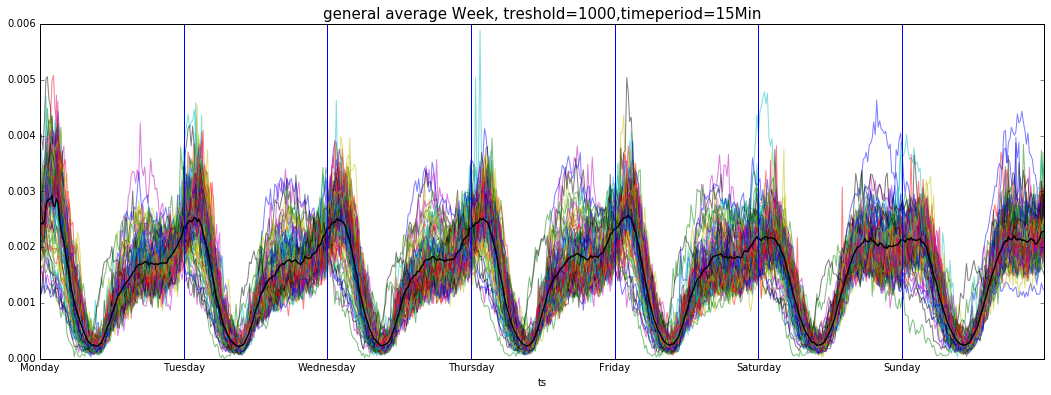

In [14]:
x = bulkWeeks(df, 'postalCode', title='general average Week', 
          av=True, th=1000, verbose=False, legend=False, tperiod='15Min')

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))


m = df[['id', 'ts']].set_index('ts').resample('1D', how='count')
proper_dates = [x.date() for x in m.index[m['id']>0].tolist()]

x = averageWeek(df,ax=ax, tperiod='6h', treshold=0, verbose=False, mask=proper_dates)

In [ ]:
fig, ax = plt.subplots(figsize=(18,7))
# week = x.T
x['id'].plot(kind='bar', ax=ax, yerr=x['std'])
ax.set_ylim(0);
ax.set_xticklabels(x.index.strftime('%a %H:%M '),minor=False)
ax.set_title('Awerage number of tweets per 6h, for each Postalcode in NYC\nwith a margin of error');

## SnowStorm

In [11]:
def get_storm_week(df):
    '''get tweets from storm week only'''
    d1 = datetime.datetime(year=2015, month=1, day=25)
    d2 = d1 + datetime.timedelta(days = 7)
    
    return df[(df.ts >= d1)&(df.ts < d2)]

In [12]:
storm = get_storm_week(df)
storm.shape[0]

262379

Index([u'id', u'std'], dtype='object')


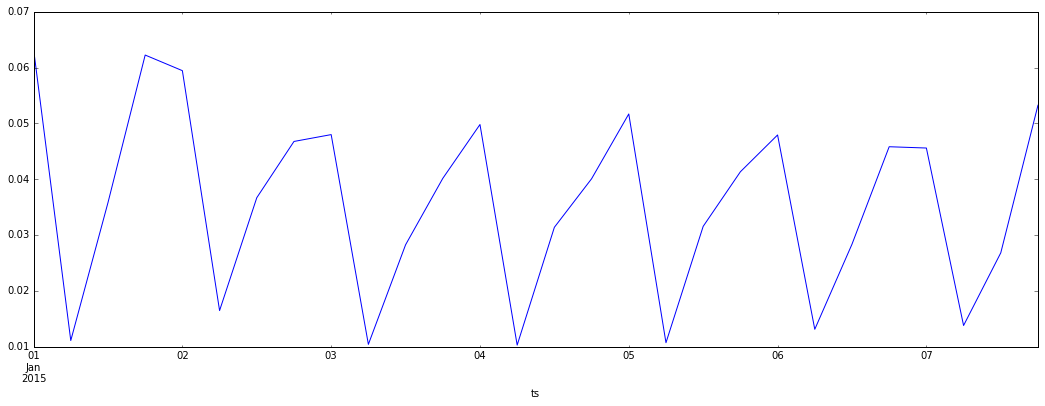

In [156]:
fig, ax = plt.subplots(figsize=(18,6))

st12h = averageWeek(storm,ax=ax, tperiod='6h', treshold=0, verbose=False, mask=proper_dates)

In [15]:
def divideBySum(df, axis=0):
    
    df2 = df.copy()
#     print df2['id']/df['id']
    df2['id'] = df2['id']/df2['id'].sum()
    df2['std'] = df2['std'] * (df2['id']/df['id'])
    return df2

In [158]:
xN, st12hN = (divideBySum(d) for d in (x, st12h) )

In [159]:
xN['storm'] = st12hN['id']

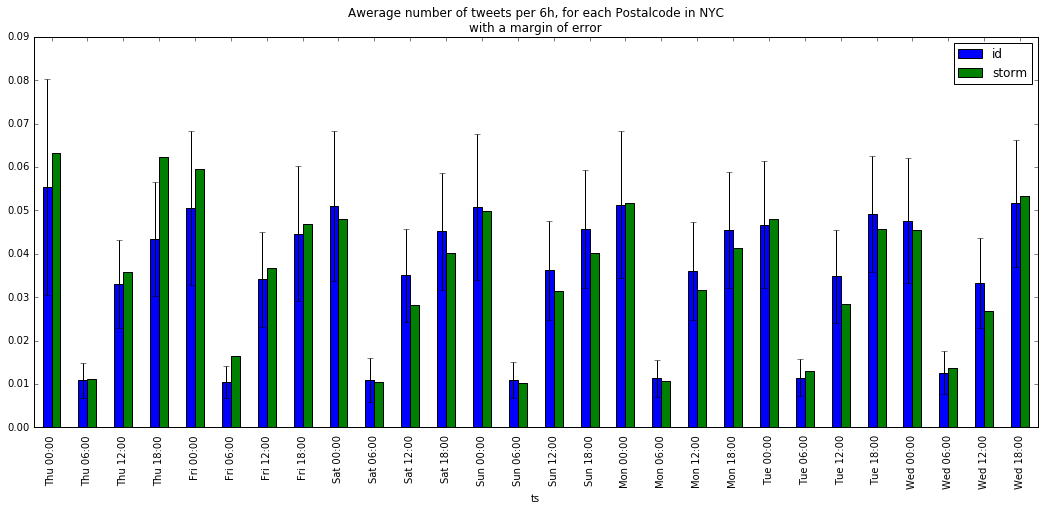

In [172]:
fig, ax = plt.subplots(figsize=(18,7))
xN[['id','storm']].plot(kind='bar', ax=ax, yerr=(xN['std'], [0]*len(xN)))

ax.set_ylim(0);
ax.set_xticklabels(x.index.strftime('%a %H:%M '),minor=False)
# ax.set_xticklabels(x.index.strftime('%a %H:%M '),minor=False)
ax.set_title('Awerage number of tweets per 6h, for each Postalcode in NYC\nwith a margin of error');

## Lower Manhattan

Index([u'id', u'std'], dtype='object')
Index([u'id', u'std'], dtype='object')


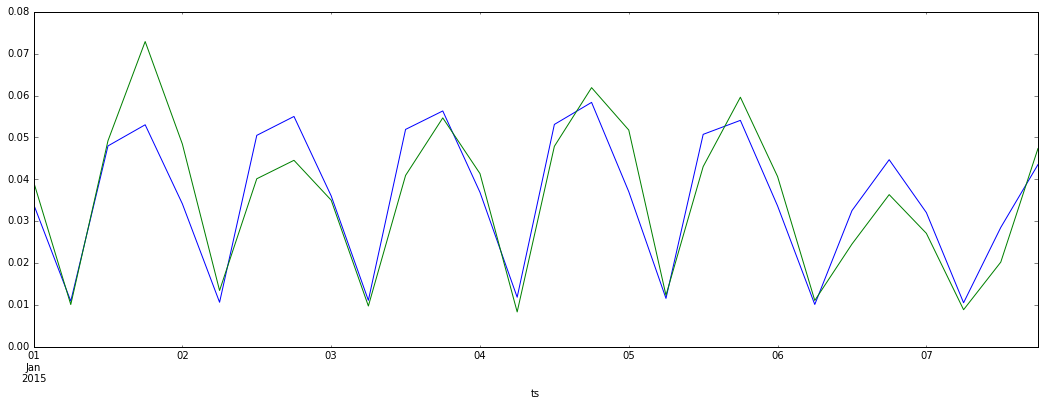

In [185]:
lm = (10038, 10004, 10280, 10007, 10013) # DownTown

fig, ax = plt.subplots(figsize=(18,6))
x1 = averageWeek(df[df.postalCode.isin(lm)],ax, tperiod='6h', label='id'  )
x2 = averageWeek(storm[storm.postalCode.isin(lm)],ax, tperiod='6h', label='id')

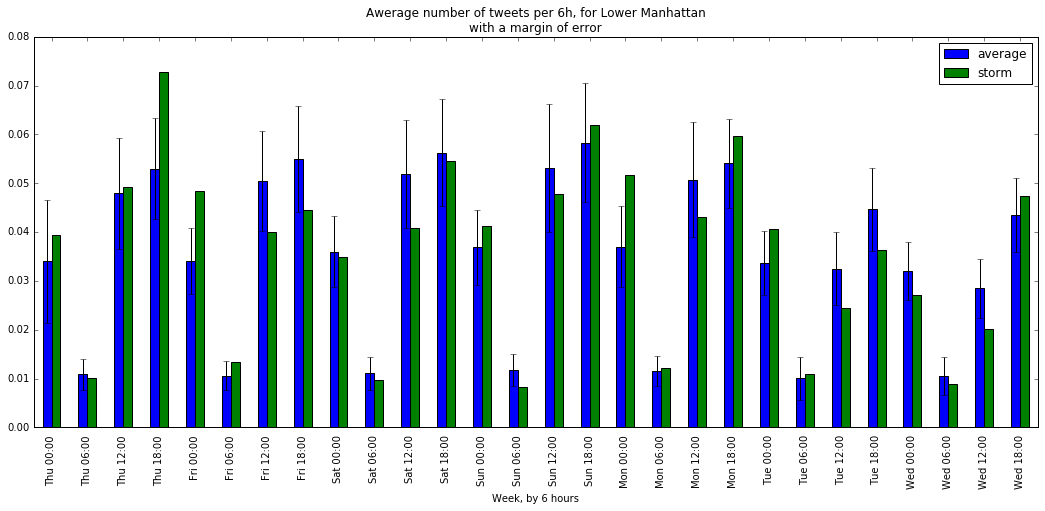

In [186]:
xN, st12hN = (divideBySum(d) for d in (x1, x2) )
xN.columns = ['average','std']
xN['storm'] = st12hN['id']
fig, ax = plt.subplots(figsize=(18,7))
xN[['average','storm']].plot(kind='bar', ax=ax, yerr=(xN['std'], [0]*len(xN)))

ax.set_ylim(0);
ax.set_xticklabels(x.index.strftime('%a %H:%M '),minor=False)
ax.set_title('Awerage number of tweets per 6h, for Lower Manhattan\nwith a margin of error');
ax.set_xlabel('Week, by 6 hours')

## Flatbush

Index([u'id', u'std'], dtype='object')
Index([u'id', u'std'], dtype='object')


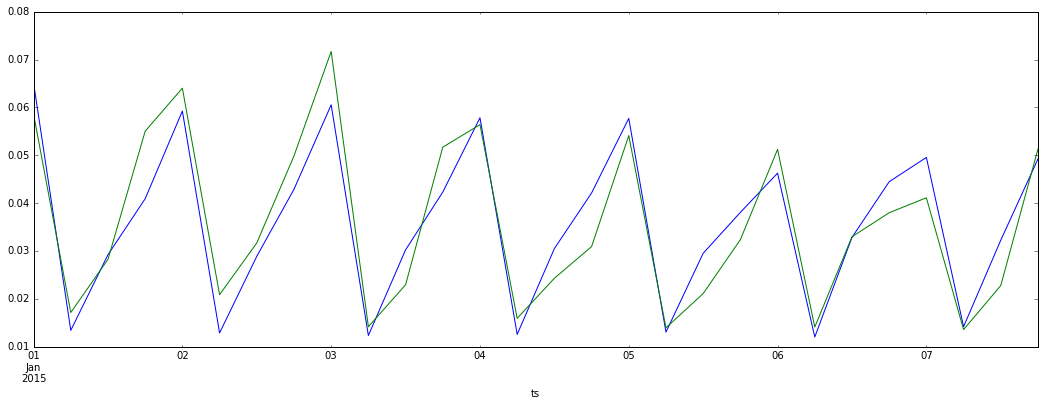

In [187]:
fb = (11204, 11240, 11223, 11229, 11210, 11235, 11224, 11214, 11228, 11209, 11220, 11219) ## flatbysg

fig, ax = plt.subplots(figsize=(18,6))
x1 = averageWeek(df[df.postalCode.isin(fb)],ax, tperiod='6h', label='id'  )
x2 = averageWeek(storm[storm.postalCode.isin(fb)],ax, tperiod='6h', label='id')

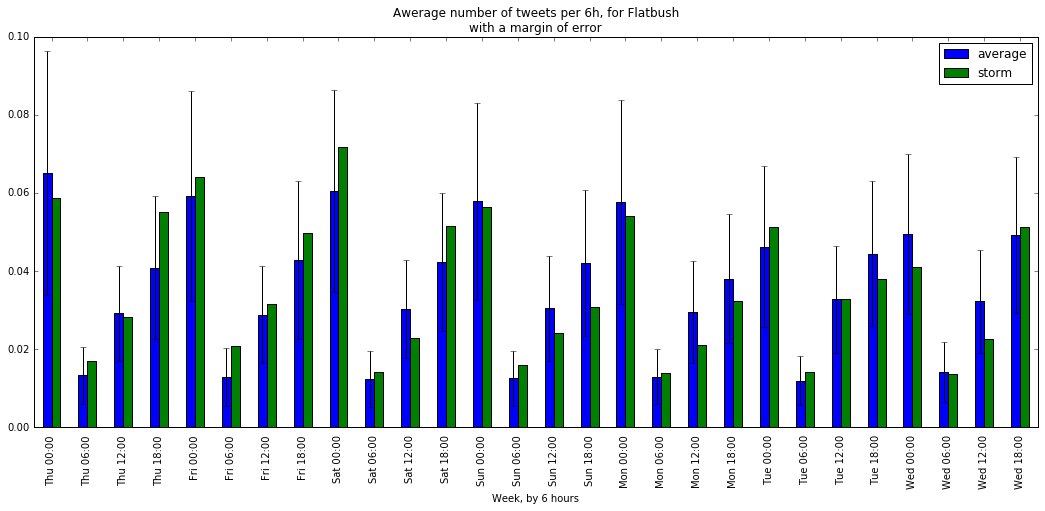

In [188]:
xN, st12hN = (divideBySum(d) for d in (x1, x2) )
xN.columns = ['average','std']
xN['storm'] = st12hN['id']
fig, ax = plt.subplots(figsize=(18,7))
xN[['average','storm']].plot(kind='bar', ax=ax, yerr=(xN['std'], [0]*len(xN)))

ax.set_ylim(0);
ax.set_xticklabels(x.index.strftime('%a %H:%M '),minor=False)
ax.set_title('Awerage number of tweets per 6h, for Flatbush\nwith a margin of error');
ax.set_xlabel('Week, by 6 hours')

### Jackson Hights

Index([u'id', u'std'], dtype='object')
Index([u'id', u'std'], dtype='object')


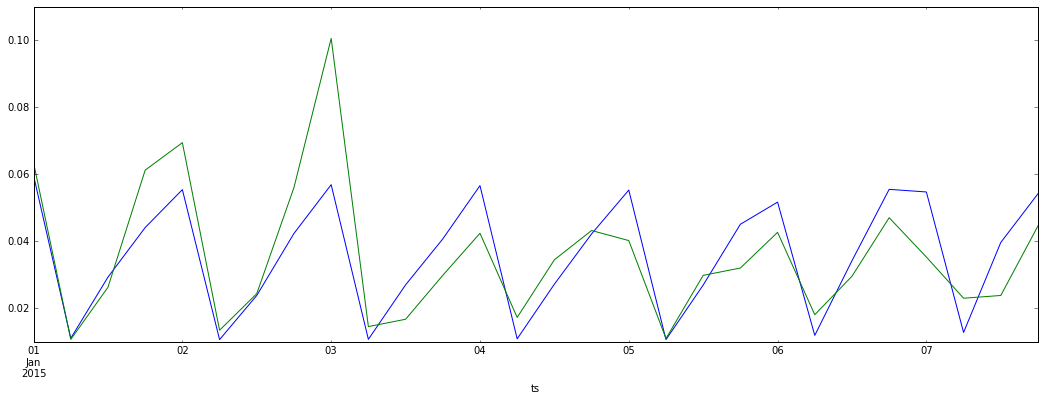

In [13]:
queens = (11373, 11372, 11368, 11373)

fig, ax = plt.subplots(figsize=(18,6))
x1 = averageWeek(df[df.postalCode.isin(queens)],ax, tperiod='6h', label='id'  )
x2 = averageWeek(storm[storm.postalCode.isin(queens)],ax, tperiod='6h', label='id')

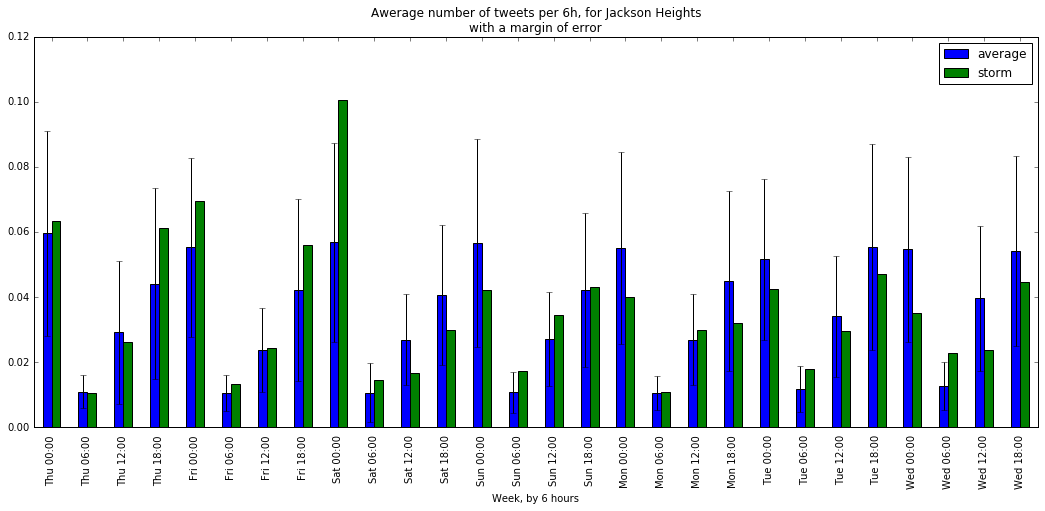

In [17]:
xN, st12hN = (divideBySum(d) for d in (x1, x2) )
xN.columns = ['average','std']
xN['storm'] = st12hN['id']
fig, ax = plt.subplots(figsize=(18,7))
xN[['average','storm']].plot(kind='bar', ax=ax, yerr=(xN['std'], [0]*len(xN)))

ax.set_ylim(0);
ax.set_xticklabels(x1.index.strftime('%a %H:%M '),minor=False)
ax.set_title('Awerage number of tweets per 6h, for Jackson Heights\nwith a margin of error');
ax.set_xlabel('Week, by 6 hours')

### Events overal

In [18]:
### for all weeks with data awailable, check if at least two (?) bins goes beyound overal std.

In [92]:
def checker(x, overal):
    '''reterns true if normalised week 
    has at least two events of goinf 
    beyound standart diviation'''
    
    below = x['id'] < (overal['id']-overal['std'])
    above = x['id'] > (overal['id']+overal['std'])
    return x[below | above].shape[0]

In [93]:
checker(awN, overalN)

1

In [94]:
overal = averageWeek(df,ax=ax, tperiod='6h', plotGraph=False, treshold=0, verbose=False, mask=proper_dates)

In [95]:
overalN = divideBySum(overal, axis=0)

### traversing through weeks

In [96]:
m = df[['id', 'ts']].set_index('ts').resample('1D', how='count')
proper_dates = [x.date() for x in m.index[m['id']>0].tolist()]

In [98]:
th=1
t2015 =  df[df.ts.dt.year==2015]

results = []
for Y in xrange(1,54):
#     print Y
    
    w = t2015[t2015.ts.dt.week==Y]
    if len(w)==0:
        pass
    else:
        aw = averageWeek(w,ax=ax, tperiod='6h', plotGraph=False, treshold=0, verbose=False, mask=proper_dates)
        if aw.shape[0]==28:
            awN = divideBySum(aw, axis=0)

            dev = checker(awN, overalN)
            if dev>th:
                results.append({'year':2015,'dev':dev, 'woy':Y})

    
pd.DataFrame(results)

,dev,woy,year
0,2,5,2015
1,4,18,2015
2,3,20,2015
3,2,23,2015


In [107]:
woy=18
x1 = averageWeek(t2015[t2015.ts.dt.week==woy],plotGraph=False, tperiod='6h', label='id'  )

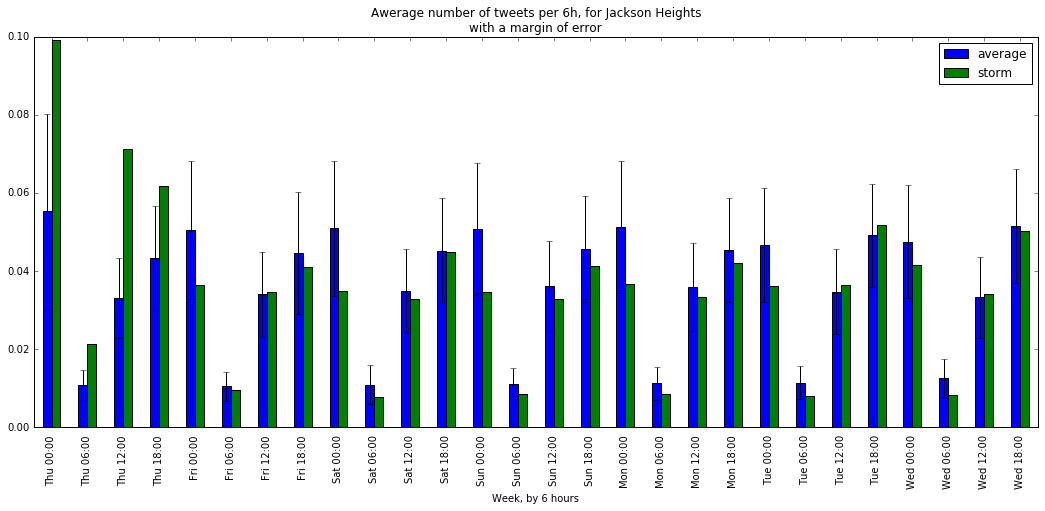

In [108]:
week = divideBySum(x1)
# overalN.columns = ['average','std', ]
overalN['storm'] = week['id']

fig, ax = plt.subplots(figsize=(18,7))
overalN[['average','storm']].plot(kind='bar', ax=ax, yerr=(overalN['std'], [0]*len(overalN)))

ax.set_ylim(0);
ax.set_xticklabels(x1.index.strftime('%a %H:%M '),minor=False)
ax.set_title('Awerage number of tweets per 6h, for Jackson Heights\nwith a margin of error');
ax.set_xlabel('Week, by 6 hours')